# Dynamic Programming for Reinforcement Learning


Suppose you have an agent interacting an envrionment whose model is known. The model of the environment contains the dynamics $p$ and the reward function $R$. We will more formally define these terms later.

The idea of dynamic programming is to solve the control problem by evaluating the value function of a state corresponding the current policy, and progressively improving upon it. Lets setup the environment as a MDP as follows:

## Markov Decision Process (MDP) Formulation

An MDP is defined by the tuple $(S, A, P, R, \gamma)$ where:

- S: finite set of states
- A: finite set of actions
- $P(s' | s, a)$: transition probability function
- $R(s, a)$: reward function
- $\gamma \in [0, 1)$: discount factor

The **state-value function** for policy $\pi$ is:

$$v_\pi(s) = \mathbb{E}_\pi[G_t | S_t = s] = \mathbb{E}_\pi\left[\sum_{k=0}^{\infty} \gamma^k R_{t+k+1} | S_t = s\right]$$

The **action-value function** is:

$$q_\pi(s, a) = \mathbb{E}_\pi[G_t | S_t = s, A_t = a]$$

The **Bellman expectation equation** for $v_\pi$ is:

$$v_\pi(s) = \sum_a \pi(a|s) \sum_{s', r} p(s', r | s, a)[r + \gamma v_\pi(s')]$$

Dynamic programming (DP) provides a collection of algorithms for computing optimal policies when we have a perfect model of the environment as a Markov Decision Process (MDP). While DP methods are limited by their assumption of a perfect model and high computational cost, they provide the theoretical foundation for understanding reinforcement learning.

## GridWorld Environment

We'll implement a classic GridWorld environment where:
- Agent moves in a 2D grid
- Goal state provides positive reward
- Obstacle states are blocked
- Each step has a small negative reward (to encourage efficiency)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

np.random.seed(42)
sns.set_style('whitegrid')

Grid size: 5x5
Number of states: 22
Number of actions: 4
Goal state: (4, 4)
Obstacles: [(1, 1), (2, 2), (3, 1)]


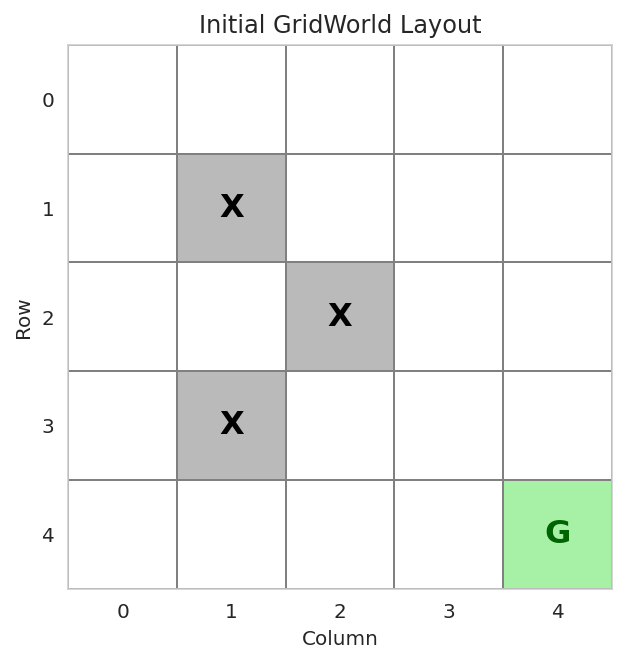

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

np.random.seed(42)
sns.set_style('whitegrid')

class GridWorld:
    """
    GridWorld MDP environment.

    Grid layout:
    - 'S': Start state
    - 'G': Goal state (+10 reward)
    - 'X': Obstacle (blocked)
    - '.': Normal state (-1 step cost)
    """

    def __init__(self, grid_size=(5, 5), goal=(4, 4), obstacles=None, gamma=0.9):
        """
        Args:
            grid_size: (height, width) of grid
            goal: (row, col) of goal state
            obstacles: list of (row, col) obstacle positions
            gamma: discount factor
        """
        self.height, self.width = grid_size
        self.goal = goal
        self.obstacles = obstacles or []
        self.gamma = gamma

        self.actions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        self.action_names = ['→', '↓', '←', '↑']
        self.n_actions = len(self.actions)

        self.states = []
        for i in range(self.height):
            for j in range(self.width):
                if (i, j) not in self.obstacles:
                    self.states.append((i, j))

        self.n_states = len(self.states)
        self.state_to_idx = {s: i for i, s in enumerate(self.states)}

    def is_terminal(self, state):
        return state == self.goal

    def get_next_state(self, state, action_idx):
        if self.is_terminal(state):
            return state

        action = self.actions[action_idx]
        next_state = (state[0] + action[0], state[1] + action[1])

        if (0 <= next_state[0] < self.height and
            0 <= next_state[1] < self.width and
            next_state not in self.obstacles):
            return next_state
        else:
            return state

    def get_reward(self, state, action_idx, next_state):
        if next_state == self.goal:
            return 10.0  # Goal reward
        else:
            return -1.0  # Step cost

    def get_transition_prob(self, state, action_idx, next_state):
        expected_next = self.get_next_state(state, action_idx)
        return 1.0 if next_state == expected_next else 0.0

    def render(self, title="GridWorld Environment"):
        plt.figure(figsize=(self.width, self.height))
        ax = plt.gca()

        for x in range(self.width + 1):
            ax.axvline(x, color='gray', lw=1)
        for y in range(self.height + 1):
            ax.axhline(y, color='gray', lw=1)

        for obs in self.obstacles:
            rect = Rectangle((obs[1], obs[0]), 1, 1, facecolor='darkgray', alpha=0.8)
            ax.add_patch(rect)
            plt.text(obs[1] + 0.5, obs[0] + 0.5, 'X', ha='center', va='center',
                     color='black', fontsize=16, fontweight='bold')

        goal_rect = Rectangle((self.goal[1], self.goal[0]), 1, 1, facecolor='lightgreen', alpha=0.8)
        ax.add_patch(goal_rect)
        plt.text(self.goal[1] + 0.5, self.goal[0] + 0.5, 'G', ha='center', va='center',
                 color='darkgreen', fontsize=16, fontweight='bold')

        ax.set_xlim(0, self.width)
        ax.set_ylim(0, self.height)
        ax.set_xticks(np.arange(0.5, self.width, 1))
        ax.set_yticks(np.arange(0.5, self.height, 1))
        ax.set_xticklabels(np.arange(self.width))
        ax.set_yticklabels(np.arange(self.height))
        ax.set_aspect('equal', adjustable='box')
        ax.invert_yaxis()

        plt.title(title)
        plt.xlabel("Column")
        plt.ylabel("Row")
        plt.grid(False)
        plt.show()

env = GridWorld(
    grid_size=(5, 5),
    goal=(4, 4),
    obstacles=[(1, 1), (2, 2), (3, 1)],
    gamma=0.9
)

print(f"Grid size: {env.height}x{env.width}")
print(f"Number of states: {env.n_states}")
print(f"Number of actions: {env.n_actions}")
print(f"Goal state: {env.goal}")
print(f"Obstacles: {env.obstacles}")

env.render("Initial GridWorld Layout")

## Policy Evaluation

**Policy evaluation** computes the state-value function $v_\pi$ for a given policy $\pi$. It iteratively applies the Bellman equation:

$$v_{k+1}(s) = \sum_a \pi(a|s) \sum_{s'} p(s'|s,a)[r(s,a,s') + \gamma v_k(s')]$$

This is guaranteed to converge to $v_\pi$ as $k \to \infty$.

**Algorithm:**
1. Initialize $V(s) = 0$ for all states
2. Repeat until convergence:
   - For each state $s$:
     - $v \leftarrow V(s)$
     - $V(s) \leftarrow \sum_a \pi(a|s) \sum_{s'} p(s'|s,a)[r + \gamma V(s')]$
     - $\Delta \leftarrow \max(\Delta, |v - V(s)|)$
   - If $\Delta < \theta$, stop

In [10]:
def policy_evaluation(env, policy, theta=1e-6, max_iterations=1000):
    V = np.zeros(env.n_states)

    for iteration in range(max_iterations):
        delta = 0

        for state_idx, state in enumerate(env.states):
            if env.is_terminal(state):
                continue

            v = V[state_idx]
            new_v = 0

            for action_idx in range(env.n_actions):
                next_state = env.get_next_state(state, action_idx)
                next_state_idx = env.state_to_idx[next_state]
                reward = env.get_reward(state, action_idx, next_state)

                new_v += policy[state_idx, action_idx] * (reward + env.gamma * V[next_state_idx])

            V[state_idx] = new_v
            delta = max(delta, abs(v - new_v))

        if delta < theta:
            print(f"Policy evaluation converged in {iteration + 1} iterations")
            return V, iteration + 1

    print(f"Policy evaluation reached max iterations ({max_iterations})")
    return V, max_iterations

uniform_policy = np.ones((env.n_states, env.n_actions)) / env.n_actions

V_uniform, iterations = policy_evaluation(env, uniform_policy)

print(f"\nValue function for uniform random policy:")
print(f"Converged in {iterations} iterations")

Policy evaluation converged in 93 iterations

Value function for uniform random policy:
Converged in 93 iterations


## Policy Iteration

**Policy iteration** alternates between:
1. **Policy Evaluation**: Compute $v_\pi$ for current policy
2. **Policy Improvement**: Update policy greedily w.r.t. $v_\pi$

$$\pi'(s) = \arg\max_a \sum_{s'} p(s'|s,a)[r(s,a,s') + \gamma v_\pi(s')]$$

The policy improvement theorem guarantees that $v_{\pi'}(s) \geq v_\pi(s)$ for all states.

**Algorithm:**
1. Initialize policy $\pi$ arbitrarily
2. Repeat:
   - **Policy Evaluation**: Compute $V = v_\pi$
   - **Policy Improvement**:
     - $\text{policy-stable} \leftarrow \text{true}$
     - For each state $s$:
       - $\text{old-action} \leftarrow \pi(s)$
       - $\pi(s) \leftarrow \arg\max_a \sum_{s'} p(s'|s,a)[r + \gamma V(s')]$
       - If $\text{old-action} \neq \pi(s)$, $\text{policy-stable} \leftarrow \text{false}$
   - If policy-stable, stop

In [12]:
def policy_iteration(env, theta=1e-6, max_iterations=100):

    policy = np.ones((env.n_states, env.n_actions)) / env.n_actions
    history = []

    for iteration in range(max_iterations):
        V, _ = policy_evaluation(env, policy, theta)
        history.append((V.copy(), policy.copy()))

        policy_stable = True
        new_policy = np.zeros((env.n_states, env.n_actions))

        for state_idx, state in enumerate(env.states):
            if env.is_terminal(state):
                continue

            action_values = np.zeros(env.n_actions)
            for action_idx in range(env.n_actions):
                next_state = env.get_next_state(state, action_idx)
                next_state_idx = env.state_to_idx[next_state]
                reward = env.get_reward(state, action_idx, next_state)
                action_values[action_idx] = reward + env.gamma * V[next_state_idx]

            best_action = np.argmax(action_values)
            new_policy[state_idx, best_action] = 1.0

            if not np.allclose(policy[state_idx], new_policy[state_idx]):
                policy_stable = False

        policy = new_policy

        if policy_stable:
            print(f"Policy iteration converged in {iteration + 1} iterations")
            return policy, V, history

    print(f"Policy iteration reached max iterations ({max_iterations})")
    return policy, V, history

optimal_policy, optimal_V, pi_history = policy_iteration(env)

print(f"\nOptimal policy found!")
print(f"Number of policy improvement steps: {len(pi_history)}")

Policy evaluation converged in 93 iterations
Policy evaluation converged in 9 iterations
Policy evaluation converged in 9 iterations
Policy iteration converged in 3 iterations

Optimal policy found!
Number of policy improvement steps: 3


## Value Iteration

**Value iteration** combines policy evaluation and improvement into a single update. It directly computes the optimal value function using the Bellman optimality equation:

$$v_{k+1}(s) = \max_a \sum_{s'} p(s'|s,a)[r(s,a,s') + \gamma v_k(s')]$$

Once the optimal value function $v_*$ is found, the optimal policy is:

$$\pi_*(s) = \arg\max_a \sum_{s'} p(s'|s,a)[r(s,a,s') + \gamma v_*(s')]$$

**Algorithm:**
1. Initialize $V(s) = 0$ for all states
2. Repeat until convergence:
   - For each state $s$:
     - $V(s) \leftarrow \max_a \sum_{s'} p(s'|s,a)[r + \gamma V(s')]$
3. Extract policy: $\pi(s) = \arg\max_a \sum_{s'} p(s'|s,a)[r + \gamma V(s')]$

In [13]:
def value_iteration(env, theta=1e-6, max_iterations=1000):

    V = np.zeros(env.n_states)
    history = []

    for iteration in range(max_iterations):
        delta = 0
        history.append(V.copy())

        for state_idx, state in enumerate(env.states):
            if env.is_terminal(state):
                continue

            v = V[state_idx]

            action_values = np.zeros(env.n_actions)
            for action_idx in range(env.n_actions):
                next_state = env.get_next_state(state, action_idx)
                next_state_idx = env.state_to_idx[next_state]
                reward = env.get_reward(state, action_idx, next_state)
                action_values[action_idx] = reward + env.gamma * V[next_state_idx]

            V[state_idx] = np.max(action_values)
            delta = max(delta, abs(v - V[state_idx]))

        if delta < theta:
            print(f"Value iteration converged in {iteration + 1} iterations")
            break

    policy = np.zeros((env.n_states, env.n_actions))
    for state_idx, state in enumerate(env.states):
        if env.is_terminal(state):
            continue

        action_values = np.zeros(env.n_actions)
        for action_idx in range(env.n_actions):
            next_state = env.get_next_state(state, action_idx)
            next_state_idx = env.state_to_idx[next_state]
            reward = env.get_reward(state, action_idx, next_state)
            action_values[action_idx] = reward + env.gamma * V[next_state_idx]

        best_action = np.argmax(action_values)
        policy[state_idx, best_action] = 1.0

    return policy, V, history

vi_policy, vi_V, vi_history = value_iteration(env)

print(f"\nOptimal policy found!")
print(f"Value iteration took {len(vi_history)} iterations")
print(f"\nVerifying policies match:")
print(f"Policy iteration == Value iteration: {np.allclose(optimal_policy, vi_policy)}")
print(f"V_PI == V_VI: {np.allclose(optimal_V, vi_V)}")

Value iteration converged in 9 iterations

Optimal policy found!
Value iteration took 9 iterations

Verifying policies match:
Policy iteration == Value iteration: True
V_PI == V_VI: True


## Visualization

Let's visualize the optimal value function and policy.

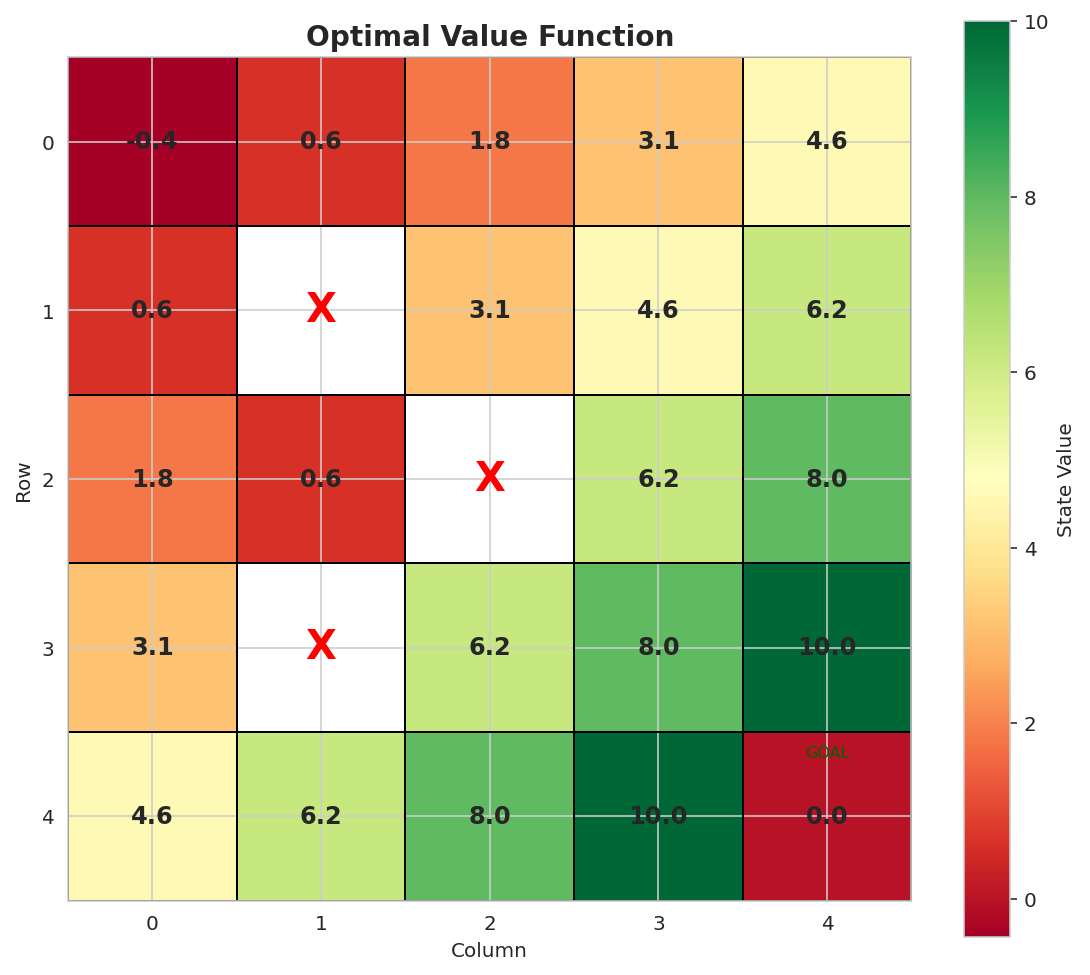

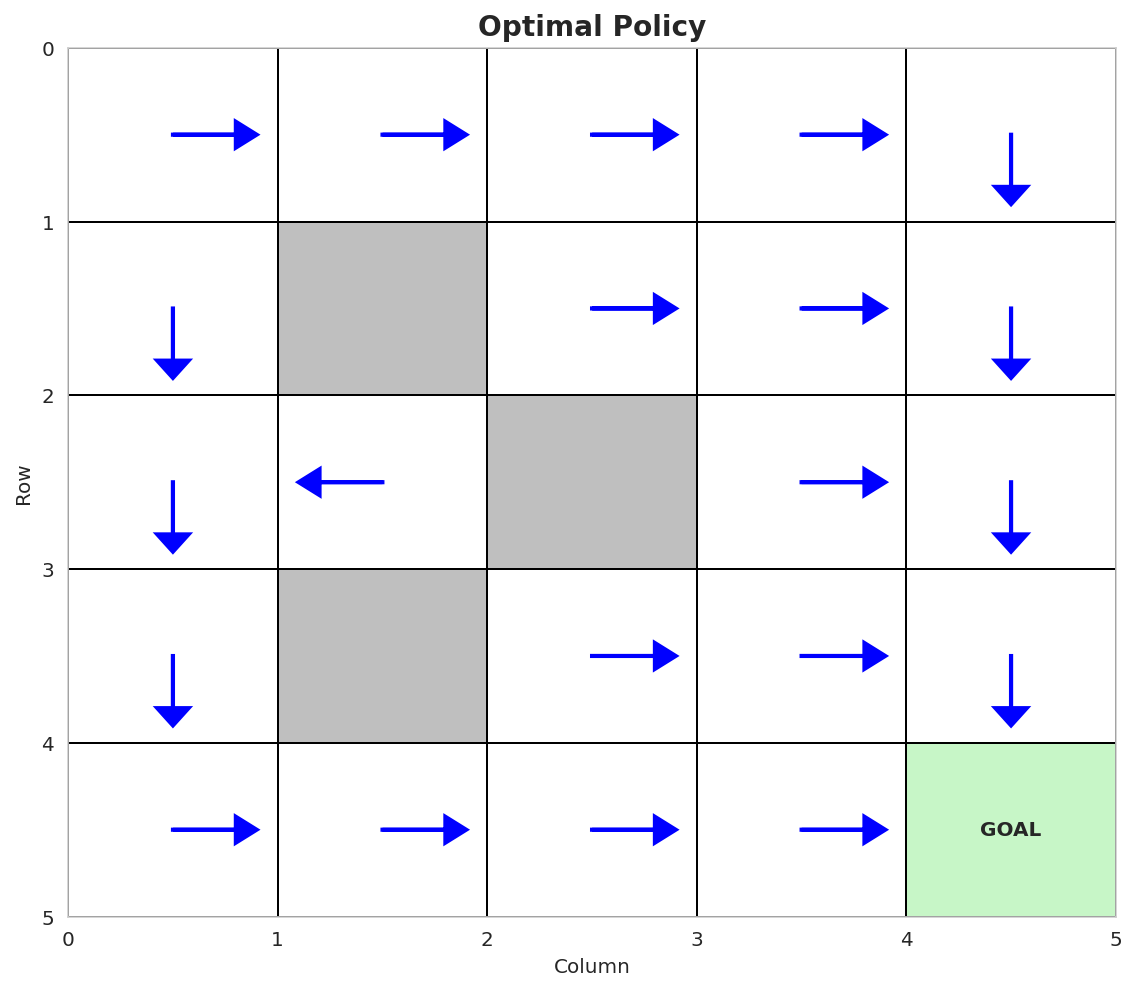

In [14]:
def plot_value_function(env, V, title="Value Function"):

    V_grid = np.full((env.height, env.width), np.nan)

    for state_idx, state in enumerate(env.states):
        V_grid[state[0], state[1]] = V[state_idx]

    plt.figure(figsize=(8, 7))
    im = plt.imshow(V_grid, cmap='RdYlGn', interpolation='nearest')
    plt.colorbar(im, label='State Value')


    for i in range(env.height + 1):
        plt.axhline(i - 0.5, color='black', linewidth=1)
    for j in range(env.width + 1):
        plt.axvline(j - 0.5, color='black', linewidth=1)


    for i in range(env.height):
        for j in range(env.width):
            if not np.isnan(V_grid[i, j]):
                plt.text(j, i, f'{V_grid[i, j]:.1f}',
                        ha='center', va='center', fontsize=12, fontweight='bold')


    goal_y, goal_x = env.goal
    plt.text(goal_x, goal_y - 0.35, 'GOAL', ha='center', fontsize=8, color='darkgreen')

    for obs in env.obstacles:
        plt.text(obs[1], obs[0], 'X', ha='center', va='center',
                fontsize=20, color='red', fontweight='bold')

    plt.title(title, fontsize=14, fontweight='bold')
    plt.xticks(range(env.width))
    plt.yticks(range(env.height))
    plt.xlabel('Column')
    plt.ylabel('Row')
    plt.tight_layout()
    plt.show()

def plot_policy(env, policy, title="Optimal Policy"):
    """Plot policy as arrows."""
    plt.figure(figsize=(8, 7))
    ax = plt.gca()


    for i in range(env.height + 1):
        plt.axhline(i, color='black', linewidth=1)
    for j in range(env.width + 1):
        plt.axvline(j, color='black', linewidth=1)


    for obs in env.obstacles:
        rect = Rectangle((obs[1], obs[0]), 1, 1, facecolor='gray', alpha=0.5)
        ax.add_patch(rect)


    goal_rect = Rectangle((env.goal[1], env.goal[0]), 1, 1,
                          facecolor='lightgreen', alpha=0.5)
    ax.add_patch(goal_rect)
    plt.text(env.goal[1] + 0.5, env.goal[0] + 0.5, 'GOAL',
            ha='center', va='center', fontsize=10, fontweight='bold')


    arrow_scale = 0.3
    for state_idx, state in enumerate(env.states):
        if env.is_terminal(state):
            continue

        action_idx = np.argmax(policy[state_idx])
        action = env.actions[action_idx]

        y, x = state[0] + 0.5, state[1] + 0.5
        dy, dx = action[0] * arrow_scale, action[1] * arrow_scale

        plt.arrow(x, y, dx, dy, head_width=0.15, head_length=0.1,
                 fc='blue', ec='blue', linewidth=2)

    plt.xlim(0, env.width)
    plt.ylim(0, env.height)
    plt.gca().invert_yaxis()
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Column')
    plt.ylabel('Row')
    plt.xticks(range(env.width + 1))
    plt.yticks(range(env.height + 1))
    plt.tight_layout()
    plt.show()


plot_value_function(env, optimal_V, "Optimal Value Function")
plot_policy(env, optimal_policy, "Optimal Policy")

## Convergence Analysis

Let's compare the convergence behavior of policy iteration vs value iteration.

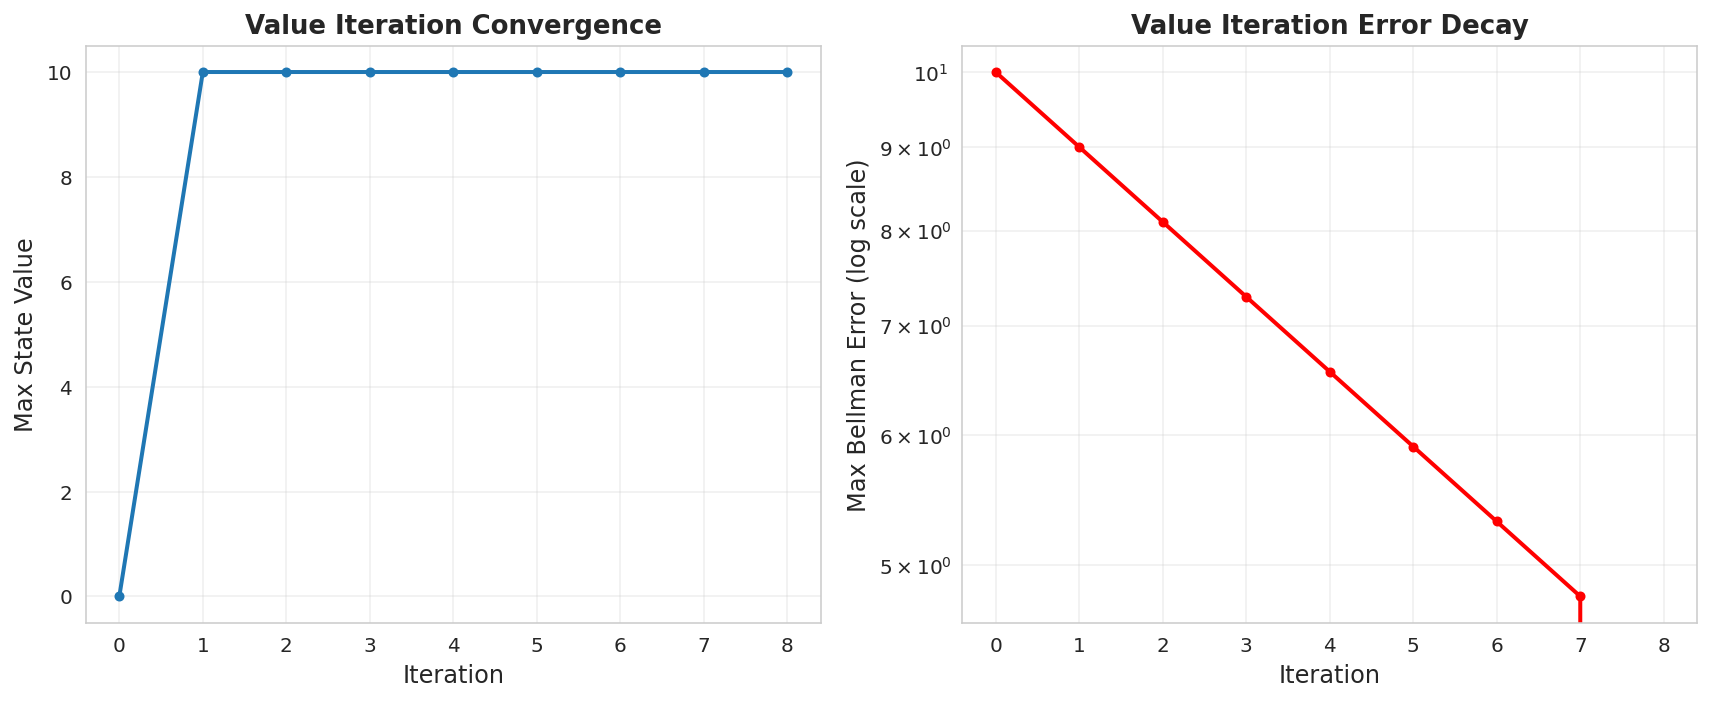


Value Iteration Statistics:
Total iterations: 9
Final max value: 10.0000
Final Bellman error: 0.00e+00


In [15]:

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
max_values = [np.max(V) for V in vi_history]
plt.plot(max_values, marker='o', linewidth=2, markersize=4)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Max State Value', fontsize=12)
plt.title('Value Iteration Convergence', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)

bellman_errors = [np.max(np.abs(V - vi_V)) for V in vi_history]
plt.semilogy(bellman_errors, marker='o', linewidth=2, markersize=4, color='red')
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Max Bellman Error (log scale)', fontsize=12)
plt.title('Value Iteration Error Decay', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print(f"\nValue Iteration Statistics:")
print(f"Total iterations: {len(vi_history)}")
print(f"Final max value: {max_values[-1]:.4f}")
print(f"Final Bellman error: {bellman_errors[-1]:.2e}")